In [185]:
import argparse
import torch
import numpy as np
import os
import json
from tqdm import tqdm
import re
import jsonlines
import PIL.Image as Image
import pickle as pkl
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
Image.MAX_IMAGE_PIXELS = None

In [192]:
# bench_json_path = "/media/zilun/fanxiang4t/GRSM/ImageRAG_git/data/train/FIT-RS-train-1415k_5para.json"
output_file_path = "/media/zilun/fanxiang4t/GRSM/ImageRAG_git/data/train/AGMLLLM_final_5para_star_obb2_0-1000.jsonl"
star_stats_path = "/media/zilun/fanxiang4t/GRSM/ImageRAG_git/codebase/dataset_process/star_statistics.pkl"
fit_img_dir = "/media/zilun/fanxiang4t/GRSM/evaluation_dataset/VQA_VG/FIT/FIT-RS/FIT-RS_Instruction/FIT-RS_Img/imgv2_split_512_100_vaild"
star_stats = pkl.load(open(star_stats_path, "rb"))

In [193]:
item_id = 699968

In [194]:
def read_jsonl(jsonl_path):
    base = [json.loads(q) for q in open(jsonl_path, "r")]
    return base

def read_json(json_path):
    with open(json_path, "r") as f:
        base = json.load(f)
    return base

In [195]:
# json_content = read_jsonl(output_file_path)
json_content = read_json(output_file_path)

In [196]:
len(json_content)

707552

In [197]:
def get_item_by_id(json_content, item_id):
    print(item_id)
    for content in tqdm(json_content):
        if content["id"] == item_id:
            print(content["id"])
            return content

In [198]:
vis_data = get_item_by_id(json_content, item_id)

699968


 40%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 284667/707552 [00:00<00:00, 2854390.04it/s]

699968


In [199]:
vis_data

{'id': 699968,
 'image': '0724__512__5768___412.png',
 'conversations': [{'from': 'human',
   'value': '<image>\n[detection]Detect all the tanks and output their locations.'},
  {'from': 'gpt',
   'value': 'There are 42 tanks in the image: <rbox>({<749.62><200.00><753.93><207.15>|<90>}, {<753.17><188.61><756.72><194.86>|<90>}, {<781.13><139.40><785.44><146.54>|<1>}, {<785.05><134.48><789.49><141.40>|<1>}, {<783.53><127.34><786.58><133.36>|<90>}, {<780.42><131.24><783.47><137.05>|<90>}, {<777.25><134.82><780.30><141.07>|<90>}, {<773.39><132.03><775.29><135.60>|<90>}, {<769.08><123.32><770.60><125.34>|<90>}, {<762.36><122.43><763.88><124.44>|<90>}, {<761.53><120.54><762.93><122.55>|<90>}, {<760.65><118.75><762.05><120.76>|<90>})</rbox>, and due to the context length, the remaining objects are not listed.'}],
 'star_image': '0724.png',
 'train_task_type': 'complex_compare',
 'star_width': 7888,
 'star_height': 4480,
 'fit_relative_pos_star': 'Top-right',
 'additional_roi_coord': {'fit': [

In [200]:
def star_denormalization(rbbox, image_w, image_h):
    """obb2poly_np_oc_2rad
    rbbox: normalzied rbbox
    return: unnormalized rbbox (deg angle)
    """
    x1, y1, x2, y2 = rbbox
    x1 = x1 / 1000 * image_w
    y1 = y1 / 1000 * image_h
    x2 = x2 / 1000 * image_w
    y2 = y2 / 1000 * image_h
    # angle_rad = math.radians(angle_deg)
    return x1, y1, x2, y2

In [201]:
star_image_name = vis_data["star_image"]
star_image_w, star_image_h, star_image_dir = star_stats[star_image_name]
additional_roi_coord = vis_data["additional_roi_coord"]

In [202]:
star_image_w, star_image_h, star_image_dir
star_img_path = os.path.join(star_image_dir, star_image_name)

In [203]:
all_roi_coord = additional_roi_coord["fit"] + additional_roi_coord["object"]

In [204]:
def obb22obb1(rbbox):
    x1, y1, x2, y2 = rbbox
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return cx, cy, w, h


def vis_bbox(img_path, list_bbox, image_w, image_h, dataset_name):

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    def draw_rotated_box(ax, vertices, color='red', alpha=0.5):
        box = patches.Polygon(np.array(vertices).reshape(-1, 2), closed=True, edgecolor=color, facecolor='none',
                              linewidth=5, alpha=alpha)
        ax.add_patch(box)

    img = plt.imread(img_path)

    # 创建一个1行2列的子图
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))

    # 可视化真实旋转边界框
    # axs.imshow(img)
    axs.set_title('Ground Truth Rotated BBoxes')
    for obb2_bbox in list_bbox:
        x1, y1, x2, y2 = star_denormalization(obb2_bbox, image_w, image_h)
        print(x1, y1, x2, y2)
        p1x, p1y, p2x, p2y, p3x, p3y, p4x, p4y = x1, y1, x2, y1, x2, y2, x1, y2
        poly = np.array([[p1x, p1y], [p2x, p2y], [p3x, p3y], [p4x, p4y]])
        print(poly)
        draw_rotated_box(axs, poly, color='red')
    axs.axis('off')  # 关闭坐标轴
    # 在子图下方显示图片路径
    axs.set_xlabel(img_path)

    # 调整子图间距
    plt.tight_layout()
    # 显示图像
    plt.show()

In [205]:
# vis_bbox(star_img_path, all_roi_coord, star_image_w, star_image_h, "star")

In [206]:
def vis_bbox(img_path, bboxes, image_w, image_h, dataset_name):
    # 读取图片
    img = np.array(Image.open(img_path))
    
    # 创建一个图形和两个子图
    fig, ax = plt.subplots(figsize=(30, 30))
    
    # 显示图片
    ax.imshow(img)
    
    # 遍历边界框列表，绘制每个边界框
    for bbox in bboxes:
        # 假设边界框格式为 (x1, y1, x2, y2)
        x1, y1, x2, y2 = star_denormalization(bbox, image_w, image_h)
        print(x1, y1, x2, y2)
        # 创建一个矩形并添加到子图
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    # 设置标题和轴标签
    ax.set_title(f'BBoxes Visualization - {dataset_name}')
    ax.set_xlabel(f'Image Width: {image_w}')
    ax.set_ylabel(f'Image Height: {image_h}')
    
    # 移除轴标记
    ax.axis('off')
    
    # 显示图形
    plt.show()

5768.0 412.0 6280.0 924.0
5909.196795909069 889.9212982851388 5950.796797840931 934.117139214861
5936.778242246264 840.7718555275137 5973.186562441237 877.1801757224863
6156.06403725615 619.3231112393298 6200.97916586885 661.6880996981702
6186.846370051819 597.4157109834067 6233.070426823182 638.5394843290934
6174.9606581312155 568.3724798241856 6210.037779368785 599.5891217383146
6151.068173634145 585.3708782893251 6184.880654490855 616.5875201481748
6124.78462907848 602.3692766700907 6161.192949046519 633.5859186424092
6097.635858704628 589.743353855211 6118.4025787953715 609.245435207289
6066.629125941335 549.2108784671145 6078.3436865586655 564.7859184078854
6013.637114222584 545.2172847171146 6025.351674839915 560.7923246578855
6006.622719718974 537.3503951297123 6018.337280281025 551.6607962765377
5999.659516593973 529.3631978640873 6011.374077156025 543.6735990109127
5909.196795909069 529.3631978640873 6233.070426823182 934.117139214861


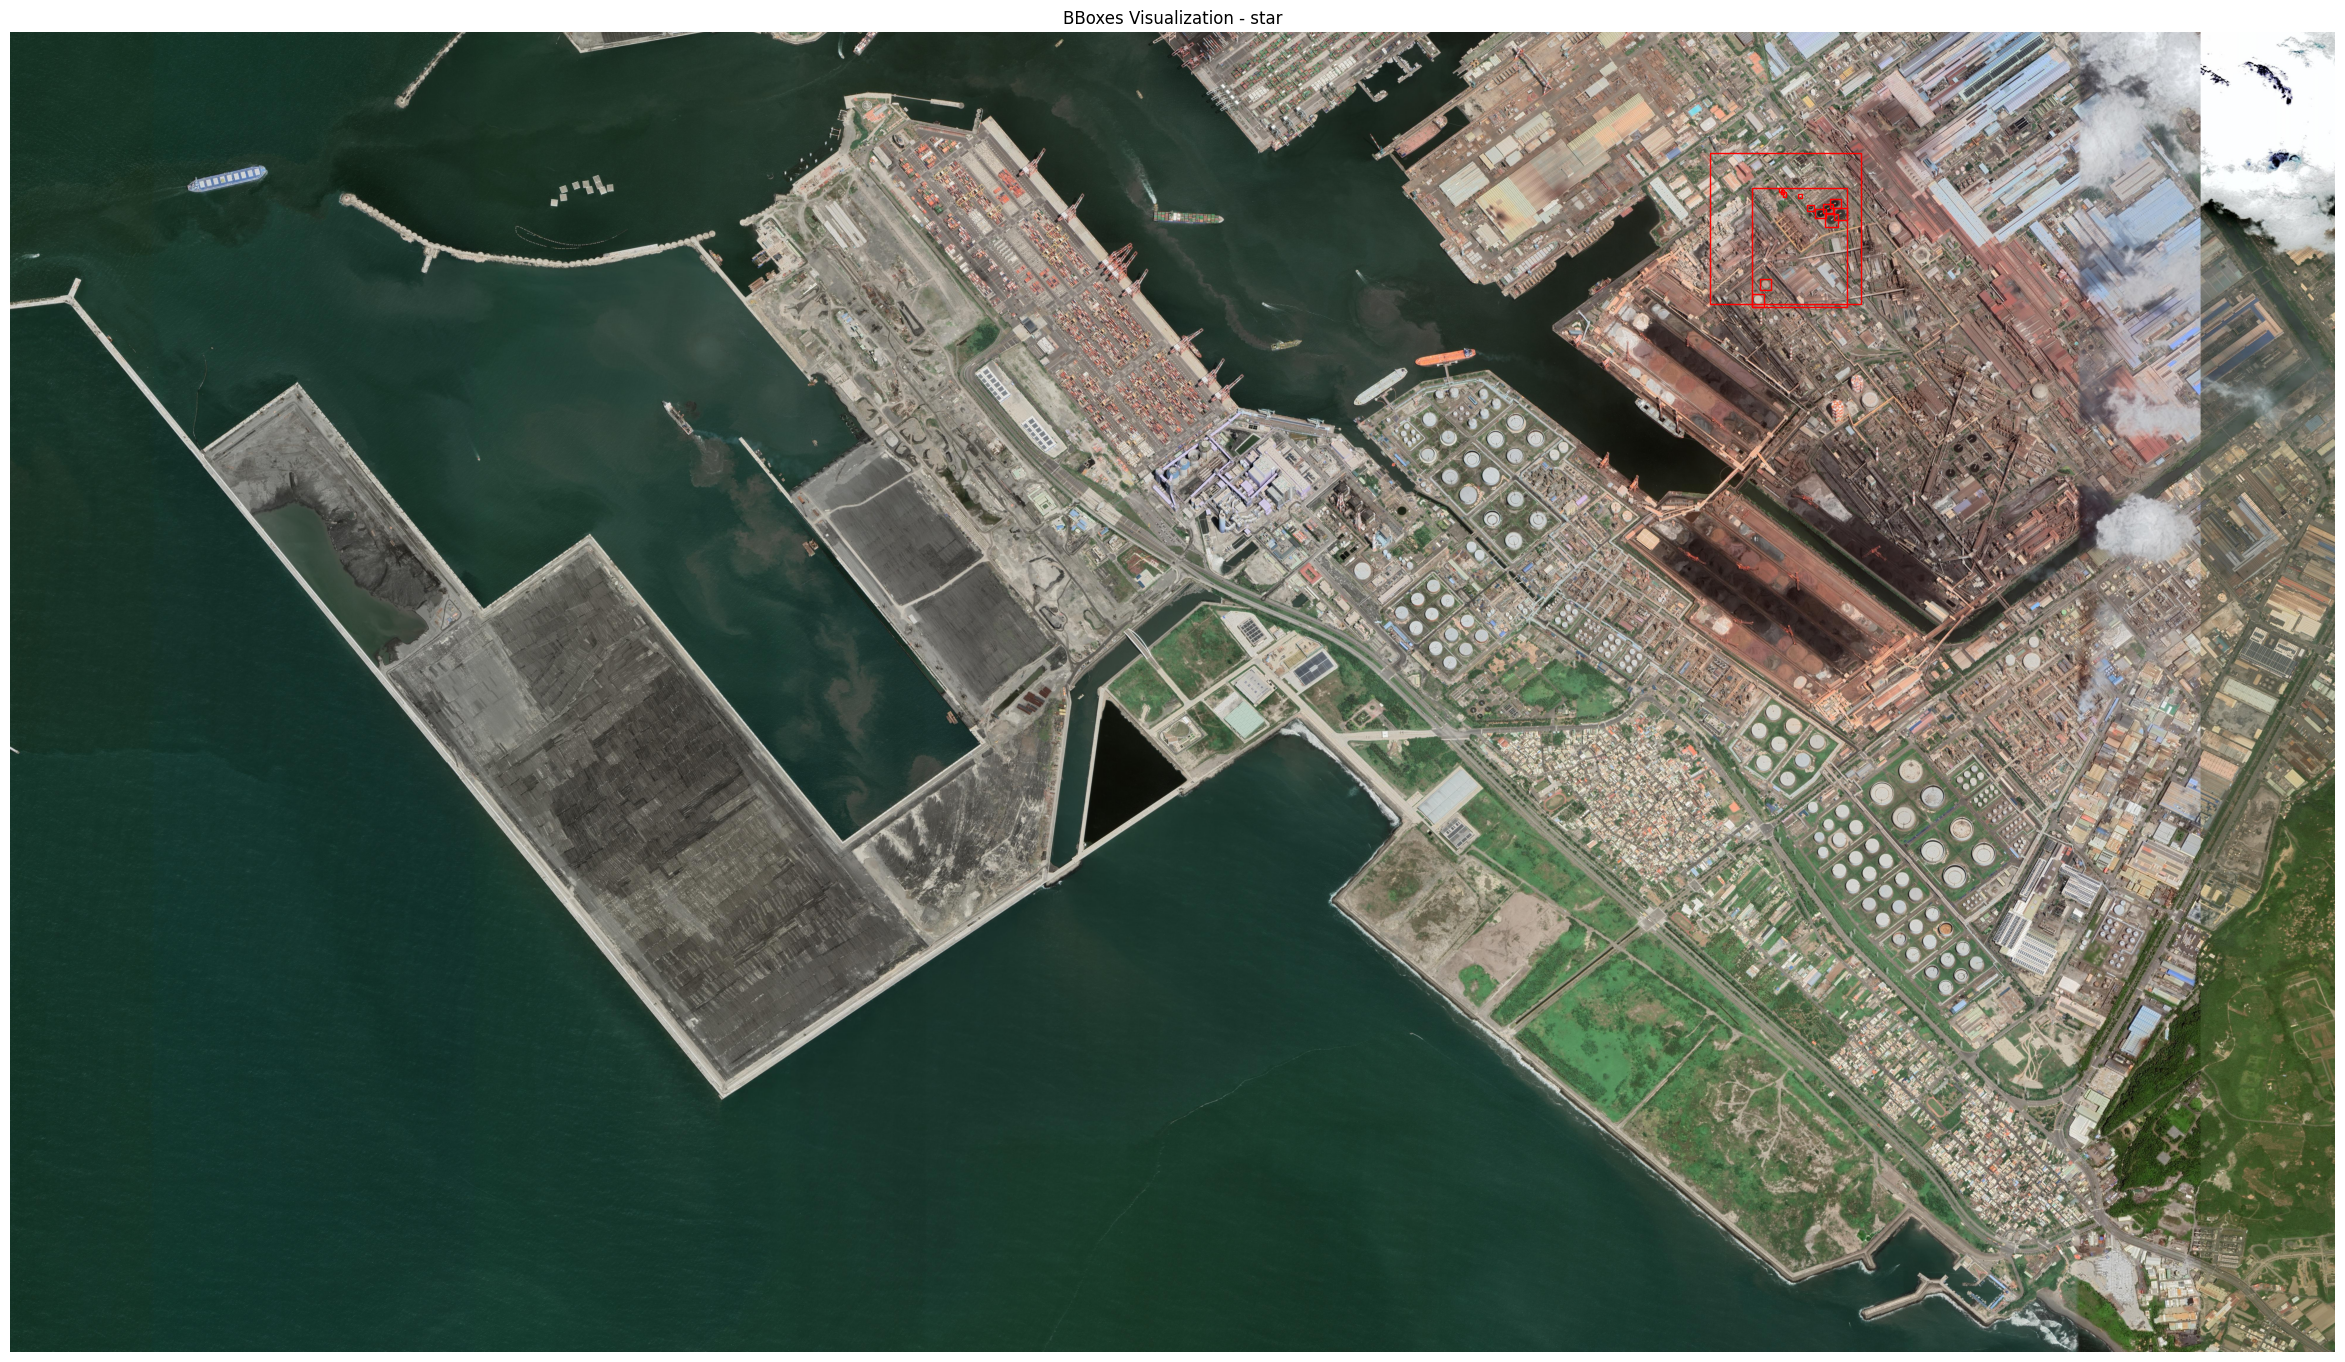

In [207]:
vis_bbox(star_img_path, all_roi_coord, star_image_w, star_image_h, "star")